## Import Necessary Libraries

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: tensorflow


## Import Data

In [2]:
#define data paths
TRAINING_DIR = "split_data/training/"
VALIDATION_DIR = "split_data/validation/"
TEST_DIR = "split_data/test/"

## Create Data Generators with Augmentation

In [3]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR):
  #create the ImageDataGenerator class for the training set
  train_datagen = ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
  
  #only apply the rescale transformation to the validation and test sets
  val_test_datagen = ImageDataGenerator(rescale=1./255)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      target_size=(224, 224))
  validation_generator = val_test_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                              batch_size=32,
                                                              class_mode='sparse',
                                                              target_size=(224, 224))
  test_generator = val_test_datagen.flow_from_directory(directory=TEST_DIR,
                                                        batch_size=32,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  return train_generator, validation_generator, test_generator


In [ ]:
#test the generators
train_generator, validation_generator, test_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR, TEST_DIR)

Found 546 images belonging to 3 classes.
Found 153 images belonging to 3 classes.
Found 81 images belonging to 3 classes.


## Baseline CNN model

In [5]:
#define function to create cnn model
def create_model():

  model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = (3,3), activation="relu", padding="same", input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(64, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 

    keras.layers.Conv2D(128, kernel_size = (3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D((2, 2)), 
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"), 
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")

  ])

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

In [6]:
#create untrained model
cnn_model = create_model()

/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
#model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
#set up early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=10,
                           restore_best_weights=True)
]

In [9]:
#train the model
history = cnn_model.fit(train_generator, validation_data=validation_generator, epochs=30, callbacks = callbacks)

Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 537ms/step - accuracy: 0.4634 - loss: 1.2525 - val_accuracy: 0.6078 - val_loss: 0.9478
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 561ms/step - accuracy: 0.5366 - loss: 1.0297 - val_accuracy: 0.5686 - val_loss: 0.9324
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 534ms/step - accuracy: 0.5495 - loss: 1.0052 - val_accuracy: 0.5752 - val_loss: 0.9070
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 521ms/step - accuracy: 0.5623 - loss: 0.9715 - val_accuracy: 0.6078 - val_loss: 0.8836
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 520ms/step - accuracy: 0.5769 - loss: 0.9488 - val_accuracy: 0.6078 - val_loss: 0.8739
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 542ms/step - accuracy: 0.5788 - loss: 0.9655 - val_accuracy: 0.6536 - val_loss: 0.8461
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 518ms/step - accuracy: 0.6007 - loss: 0.8975 - val_accuracy: 0.6471 - val_loss: 0.8025
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 529ms/step - accuracy: 0.6007 - loss: 0.9213 - val_accu

## Display Training Progress

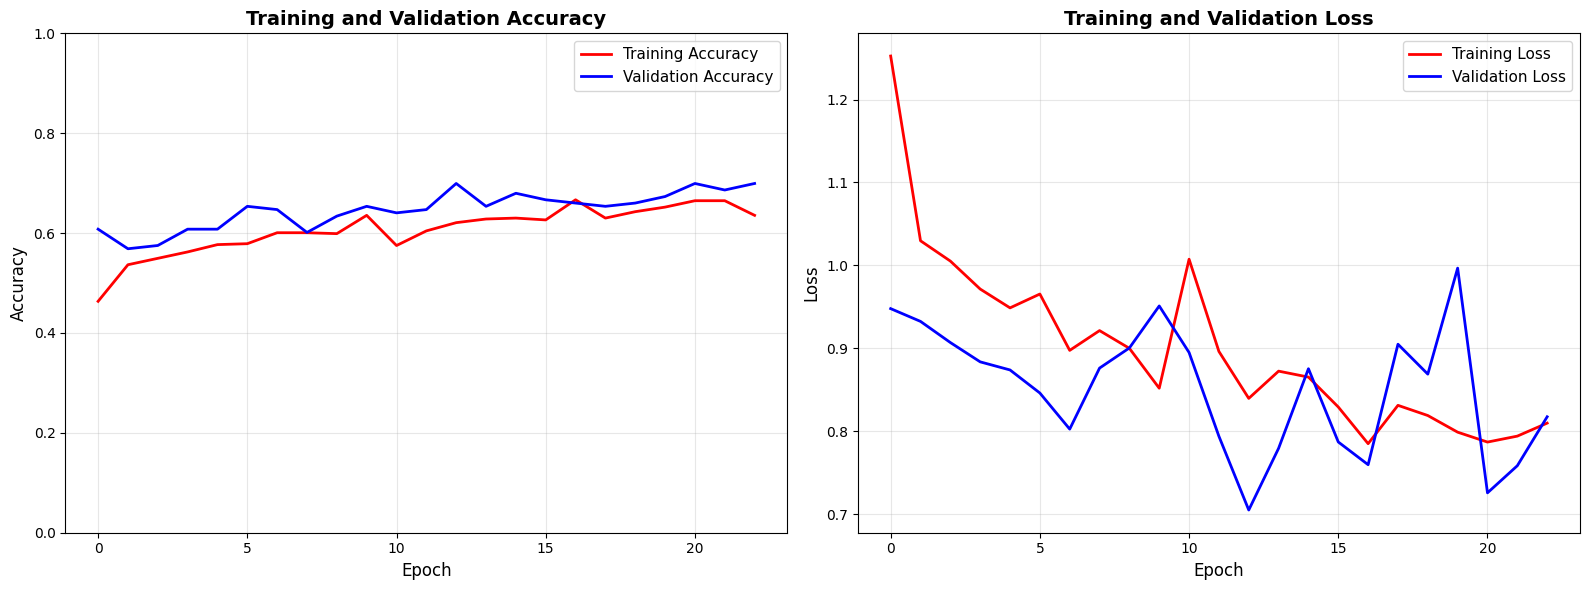


  Training Summary
  Best Training Accuracy:   0.6667 (epoch 17)
  Best Validation Accuracy: 0.6993 (epoch 13)
  Final Training Accuracy:  0.6355
  Final Validation Accuracy:0.6993
  Accuracy Gap (final):     0.0638


In [10]:
#training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#get number of epochs actually executed with early stopping
epochs_range = range(len(acc))

#create plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

#plot accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

#plot loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#print summary stats
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

## Evaluate model

In [11]:
#get test accuracy and loss
preds = cnn_model.evaluate(test_generator)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5802 - loss: 1.1998
Loss = 1.199798583984375
Test Accuracy = 0.5802469253540039


In [12]:
#evaluate on val set
validation_generator.shuffle = False
y_true = validation_generator.classes
y_pred_probs = cnn_model.predict(validation_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Val Classification Report:")
print(classification_report(y_true, y_pred, target_names=validation_generator.class_indices.keys()))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step
Val Classification Report:
              precision    recall  f1-score   support

      benign       0.58      0.79      0.67        87
   malignant       0.46      0.39      0.42        41
      normal       0.00      0.00      0.00        25

    accuracy                           0.56       153
   macro avg       0.35      0.39      0.36       153
weighted avg       0.46      0.56      0.50       153



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

In [13]:
#evaluate on test set
test_generator.shuffle = False
y_true = test_generator.classes
y_pred_probs = cnn_model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step
Test Classification Report:
              precision    recall  f1-score   support

      benign       0.50      0.66      0.57        44
   malignant       0.13      0.14      0.13        22
      normal       0.00      0.00      0.00        15

    accuracy                           0.40        81
   macro avg       0.21      0.27      0.23        81
weighted avg       0.31      0.40      0.35        81



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

In [14]:
#evaluate on train set
train_generator.shuffle = False
y_true = train_generator.classes
y_pred_probs = cnn_model.predict(train_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Train Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step
Train Classification Report:
              precision    recall  f1-score   support

      benign       0.55      0.75      0.64       306
   malignant       0.24      0.21      0.22       147
      normal       0.00      0.00      0.00        93

    accuracy                           0.48       546
   macro avg       0.26      0.32      0.29       546
weighted avg       0.38      0.48      0.42       546



/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sofielangenhuizen/Desktop/STAT_362/stat263-finalproject/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl